**<center><h1>Automating Customer Support with CrewAI's Multi-Agent Solution</h1></center>**

n this notebook, we will create a multi-agent support system using CrewAI, demonstrating the functionality and collaboration of agents in dynamic environments. Agents in multi-agent systems are autonomous entities designed to perform specialized tasks, work in coordination, and solve complex problems collectively. This notebook serves as a practical application of key concepts from the [Multi-Agent Systems with CrewAI](https://www.deeplearning.ai/short-courses/multi-ai-agent-systems-with-crewai/) course by **DeepLearning.AI** and **CrewAI**. Through hands-on examples, we will explore how these agents operate as a cohesive crew to achieve sophisticated objectives efficiently.

## **Table of Contents**

* [Step 1. Multi-Agent Support System : Detailed Overview](#h1)

* [Step 2. Memory Types](#h2)

* [Step 3. Install Libraries](#h3)

* [Step 4. Import Libraries](#h4)

* [Step 5. Define Agents](#h5)

* [Step 6. Define Tools](#h6)

* [Step 7. Define Tasks](#h7)

* [Step 8. Creating the Crew](#h8)

* [Step 9. Running the Crew](#h9)

## **Step 1. Multi-Agent Support System : Detailed Overview** <a class="anchor"  id="h1"></a>

In this notebook, we implement a multi-agent support system to enhance customer service interactions using CrewAI.

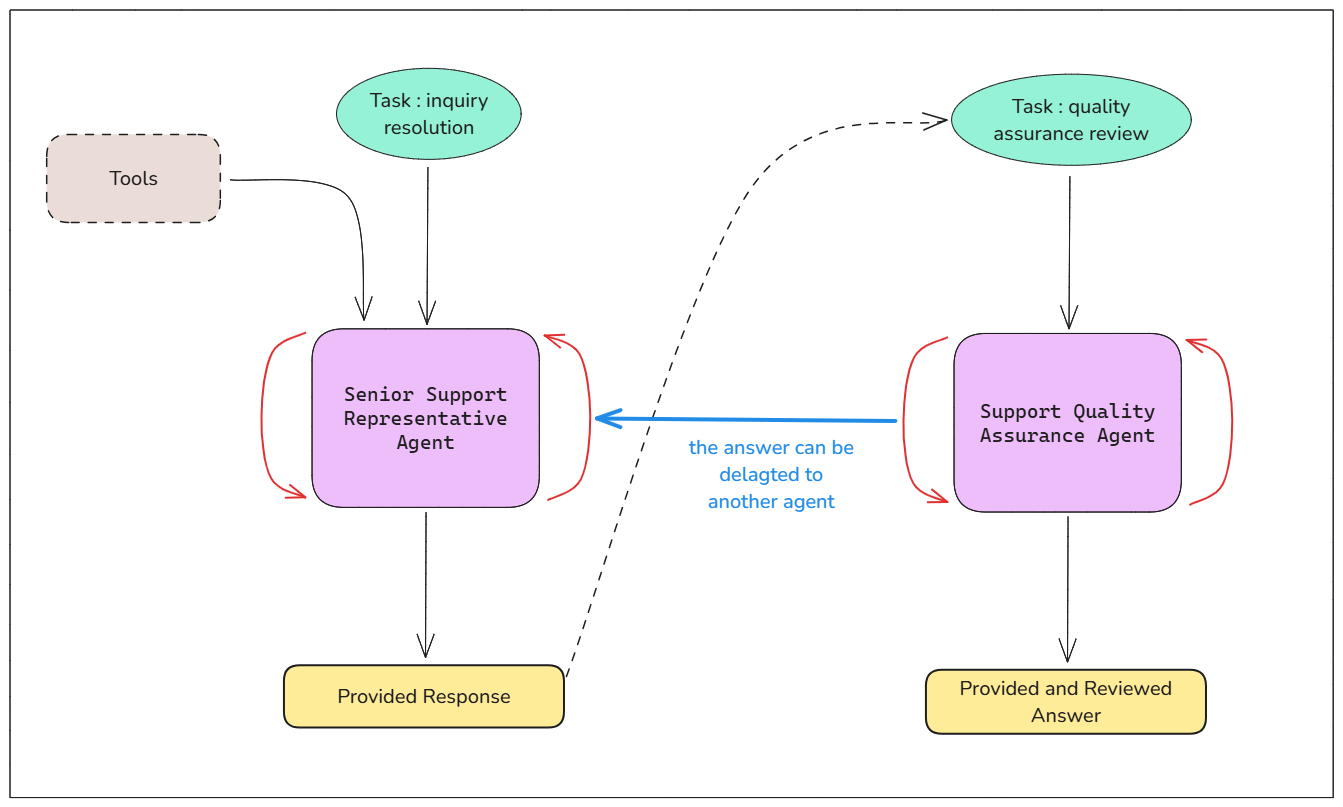

Our approach involves two agents with distinct roles to ensure thorough and high-quality responses to customer inquiries:

- **Agent 1: Senior Support Representative (`support_agent`)**
    - **Role**: Acts as the friendliest and most helpful representative, aiming to provide comprehensive support.
    - **Backstory**: Works at CrewAI, dedicated to assisting an important customer with clear, assumption-free responses.
    - **Task - Inquiry Resolution**:
        - Analyzes customer inquiries to provide complete, accurate responses.
        - Utilizes a data scraping tool (`docs_scrape_tool`) to gather relevant information from websites or documents, enriching responses with supporting details.
        - Strives to create well-referenced, customer-focused answers that fully address the customer's questions.

- **Agent 2: Support Quality Assurance Specialist (`support_quality_assurance_agent`)**
    - **Role**: Ensures that the `support_agent`’s response meets CrewAI’s standards of completeness, accuracy, and a friendly tone.
    - **Backstory**: Works alongside the support team at CrewAI, ensuring the highest quality of customer responses.
    - **Task - Quality Assurance Review**:
        - Evaluates the `support_agent`'s response to verify it is comprehensive, well-referenced, and addresses all parts of the customer inquiry.
        - If any part of the response falls short, it can **delegate** the response back to the `support_agent` for reshaping or modification until it meets the required standards.

Together, these agents provide a customer support experience that is thorough, well-researched, and approachable. This system, with its added delegation feature, is designed to ensure responses meet high standards, leaving customers with a positive experience.

## **Step 2. Memory Types** <a class="anchor"  id="h2"></a>

In our implementation of the CrewAI multi-agent system, we utilize a comprehensive memory architecture that enhances the agents' effectiveness. The key components of this memory system are:

- **Short-Term Memory:**
  - Temporarily stores recent interactions and outcomes using Retrieval-Augmented Generation (RAG), enabling agents to recall and utilize relevant information during current executions. 
  - This memory exists only during the crew execution, resetting each time a crew is initiated, and is shared among all agents, facilitating contextual sharing throughout the execution.

- **Long-Term Memory:**
  - Preserves valuable insights and learnings from past executions, allowing agents to build and refine their knowledge over time. 
  - Stored in a local database, this memory persists even after the crew execution, enabling agents to self-critique their outputs based on previous experiences and leading to `self-improving` agents.

- **Entity Memory:**
  - Captures and organizes information about entities (people, places, concepts) encountered during tasks, facilitating deeper understanding and relationship mapping. 
  - This memory is active only during execution and retains the subjects discussed, utilizing RAG for effective storage.

- **Contextual Memory:**
  - Maintains the context of interactions by integrating Short-Term, Long-Term, and Entity Memory, ensuring coherence and relevance in agent responses throughout a sequence of tasks or conversations.

In our case, we will set `memory=True`, which will enable all these memory components (Short-Term Memory, Long-Term Memory, and Entity Memory), significantly enhancing the agents' ability to function effectively within the crew.

 ## **Step 3. Install Libraries** <a class="anchor"  id="h3"></a>

In [1]:
%%capture
! pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

## **Step 4. Import Libraries** <a class="anchor"  id="h4"></a>

In [2]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In this notebook, we are going to use `gpt-4o-mini` by OpenAI which is the default llm used in CrewAI.

In [3]:
from crewai import Agent, Task, Crew
import os

os.environ["OPENAI_API_KEY"] = "****************************************"

## **Step 5. Define Agents** <a class="anchor"  id="h5"></a>

#### **Agent : Senior Support Representative**

In [4]:
support_agent = Agent(
    role="Senior Support Representative",
    goal="Be the most friendly and helpful "
        "support representative in your team",
    backstory=(
        "You work at crewAI (https://crewai.com) and "
        " are now working on providing "
        "support to {customer}, a super important customer "
        " for your company."
        "You need to make sure that you provide the best support!"
        "Make sure to provide full complete answers, "
        " and make no assumptions."
    ),
    allow_delegation=False,
    verbose=True
)

#### **Agent : Support Quality Assurance Specialist**

In [5]:
support_quality_assurance_agent = Agent(
    role="Support Quality Assurance Specialist",
    goal="Get recognition for providing the "
    "best support quality assurance in your team",
    backstory=(
        "You work at crewAI (https://crewai.com) and "
        "are now working with your team "
        "on a request from {customer} ensuring that "
        "the support representative is "
        "providing the best support possible.\n"
        "You need to make sure that the support representative "
        "is providing full"
        "complete answers, and make no assumptions."
    ),
    verbose=True
)

## **Step 6. Define Tools** <a class="anchor"  id="h6"></a>

Tools enable agents to interact with the external world. They are designed to be versatile, fault-tolerant, and implement caching mechanisms.

- **Versatile**: A tool should be capable of accepting and handling various types of requests. It serves as a bridge between AI applications, which often deal with ambiguous inputs, and the external world. The tool must be versatile enough to accommodate the diverse outputs that a large language model (LLM) may produce. CrewAI effectively supports the conversion of arguments into the appropriate types.

- **Fault-Tolerant**: When agents utilize tools, exceptions may occur. In such cases, we aim for the execution to continue without interruption, allowing the agent to fail gracefully and attempt the action again. CrewAI implements this by ensuring that even if an exception arises during tool execution, the error message is communicated back to the user. This allows the agent to take corrective action, resulting in self-healing agents.

- **Caching**: Caching is essential for optimizing tool usage. CrewAI offers cross-agent caching, which is an intelligent caching system. When an agent attempts to use a tool with a unique set of arguments, and another agent uses the same tool with identical arguments—regardless of their differences—both will access a cache layer. This means that subsequent calls to the tool won't require additional API requests, thereby preventing unnecessary calls and saving execution time.

Next, we will import the tools that our agents will utilize in the CrewAI system. CrewAI offers a variety of powerful tools designed for tasks such as web scraping, and users can also define their own custom tools as needed. Here’s a brief overview of some tools provided by CrewAI:

- **SerperDevTool:** This tool enables agents to perform Google searches, allowing them to quickly gather information from a wide range of online sources.
- **ScrapeWebsiteTool:** This tool grants agents the capability to access a specified URL and extract its content, providing valuable data directly from web pages.
- **WebsiteSearchTool:** Utilizing Retrieval-Augmented Generation (RAG), this tool performs semantic searches over the content of a website, enhancing the ability to retrieve relevant information.

For our specific use case, we will primarily utilize the **SerperDevTool** to facilitate efficient information retrieval and support our agents in providing accurate and helpful responses.

In [6]:
from crewai_tools import SerperDevTool, \
                         ScrapeWebsiteTool, \
                         WebsiteSearchTool

In [7]:
docs_scrape_tool = ScrapeWebsiteTool(
    website_url="https://docs.crewai.com/concepts/memory"
)

## **Step 7. Define Tasks** <a class="anchor"  id="h7"></a>

Define your Tasks, and provide them a description, expected_output and agent.

#### **Task : Inquiry Resolution**

In [8]:
inquiry_resolution = Task(
    description=(
        "{customer} just reached out with a super important ask:\n"
        "{inquiry}\n\n"
        "{person} from {customer} is the one that reached out. "
        "Make sure to use everything you know "
        "to provide the best support possible."
        "You must strive to provide a complete "
        "and accurate response to the customer's inquiry."
    ),
    expected_output=(
        "A detailed, informative response to the "
        "customer's inquiry that addresses "
        "all aspects of their question.\n"
        "The response should include references "
        "to everything you used to find the answer, "
        "including external data or solutions. "
        "Ensure the answer is complete, "
        "leaving no questions unanswered, and maintain a helpful and friendly "
        "tone throughout."
    ),
    tools=[docs_scrape_tool],
    agent=support_agent,
)

#### **Task : Quality Assurance Review**

In [9]:
quality_assurance_review = Task(
    description=(
        "Review the response drafted by the Senior Support Representative for {customer}'s inquiry. "
        "Ensure that the answer is comprehensive, accurate, and adheres to the "
        "high-quality standards expected for customer support.\n"
        "Verify that all parts of the customer's inquiry "
        "have been addressed "
        "thoroughly, with a helpful and friendly tone.\n"
        "Check for references and sources used to "
        " find the information, "
        "ensuring the response is well-supported and "
        "leaves no questions unanswered."
    ),
    expected_output=(
        "A final, detailed, and informative response "
        "ready to be sent to the customer.\n"
        "This response should fully address the "
        "customer's inquiry, incorporating all "
        "relevant feedback and improvements.\n"
        "Don't be too formal, we are a chill and cool company "
        "but maintain a professional and friendly tone throughout."
    ),
    agent=support_quality_assurance_agent,
)


## **Step 8. Creating the Crew** <a class="anchor"  id="h8"></a>

- Create your crew of Agents
- Pass the tasks to be performed by those agents.
    - Note: For this simple example, the tasks will be performed sequentially (i.e they are dependent on each other), so the order of the task in the list matters.
- verbose=True allows you to see all the logs of the execution.
- memory=True allows the usage of Short-Term Memory, Long-Term Memory and Entity Memory.

In [10]:
crew = Crew(
    agents=[
        support_agent, 
        support_quality_assurance_agent
    ],
    tasks=[
        inquiry_resolution, 
        quality_assurance_review
    ],
    verbose=True,
    memory=True,
)

In [11]:
print(crew.embedder)

{'provider': 'openai'}


## **Step 9. Running the Crew** <a class="anchor"  id="h9"></a>

As illustrated below, the interaction resembles a dialogue between the Senior Support Representative Agent and the Support Quality Assurance Specialist Agent. Initially, the Senior Support Representative Agent scrapes the provided website and generates a response. This answer is then forwarded to the Support Quality Assurance Specialist Agent, who ensures its completeness and accuracy. To verify the information, the Support Quality Assurance Specialist Agent asks the Senior Support Representative Agent, "Can you confirm that all the information and references provided in your response are accurate and relevant?" Once the Senior Support Representative Agent confirms the accuracy of the details, we arrive at the final response. This process exemplifies an internal discussion between agents, ultimately leading to a reliable and accurate answer.

In [15]:
inputs = {
    "customer": "DeepLearningAI",
    "person": "Andrew Ng",
    "inquiry": "I need help with setting up a Crew "
               "and kicking it off, specifically "
               "What are the types of memories in a crew?"
               "Can you provide guidance?"
}
result = crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Senior Support Representative
 [INFO]: == Starting Task: DeepLearningAI just reached out with a super important ask:
I need help with setting up a Crew and kicking it off, specifically What are the types of memories in a crew?Can you provide guidance?

Andrew Ng from DeepLearningAI is the one that reached out. Make sure to use everything you know to provide the best support possible.You must strive to provide a complete and accurate response to the customer's inquiry.


> Entering new CrewAgentExecutor chain...
The customer's question is about the types of memories in a crew in the CrewAI system. To provide accurate and helpful information, I need to consult the official documentation on the company's website.

Action: 
Read website content

Action Input: 
{"url": "https://docs.crewai.com/concepts/memory"} 
 

Memory - CrewAICrewAI home pageSearch CrewAI docscrewAIInc/crewAIcrewAIInc/crewAISearchNavigationCore ConceptsMemoryGet StartedExamplesCrewAI home pag

In [16]:
from IPython.display import Markdown
Markdown(result)

Dear Andrew,

Thank you for reaching out with your inquiry about our memory system. We understand how important this feature is for you to effectively utilize our AI technology.

The CrewAI system introduces a sophisticated memory system designed to significantly enhance the capabilities of AI agents. Here are the types of memories in a CrewAI system:

1. **Short-Term Memory**: This temporarily stores recent interactions and outcomes using RAG (Retrieval-Augmented Generation), enabling agents to recall and utilize information relevant to their current context during the current executions.

2. **Long-Term Memory**: This preserves valuable insights and learnings from past executions, allowing agents to build and refine their knowledge over time.

3. **Entity Memory**: This captures and organizes information about entities (people, places, concepts) encountered during tasks, facilitating deeper understanding and relationship mapping. It uses RAG for storing entity information.

4. **Contextual Memory**: This maintains the context of interactions by combining Short-Term Memory, Long-Term Memory, and Entity Memory, aiding in the coherence and relevance of agent responses over a sequence of tasks or a conversation.

When configuring a crew, you can enable and customize each memory component to suit the crew’s objectives and the nature of tasks it will perform. By default, the memory system is disabled, and you can ensure it is active by setting memory=True in the crew configuration. 

Here is an example of how you can configure memory for a crew: 

```python 
from crewai import Crew, Agent, Task, Process 
# Assemble your crew with memory capabilities 
my_crew = Crew( 
  agents=[...], 
  tasks=[...], 
  process=Process.sequential, 
  memory=True, 
  verbose=True 
)
``` 

I hope this information is helpful to you, and I encourage you to check out the [official documentation](https://docs.crewai.com/concepts/memory) for more detailed information and examples. We are here to support you in this process, so please don't hesitate to reach out if you have any further questions or need additional assistance! 

Best regards, 
[Your Name]